In [1]:
# --- Notebook setup ---
import os, json, glob, re
from collections import defaultdict, Counter
from dataclasses import dataclass
from typing import Dict, List, Tuple, Any, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paths (edit as needed)
DATA_FILE = "twoDiscussion_interAgentRating_7agents_2werewolves_2werewolfDiscussionRounds/game_7agents_2rounds_Silent Hunter_run1.json"

DATA_FOLDER = os.path.dirname(DATA_FILE)  # for batch later

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)


In [2]:
def load_game(path: str) -> dict:
    with open(path, "r") as f:
        return json.load(f)

game = load_game(DATA_FILE)

# Quick peek
pd.DataFrame([game["metadata"]])


,archetypes,num_agents,num_werewolves,discussion_rounds,werewolf_archetype,roles
0,"{'Agent0': 'default', 'Agent1': 'default', 'Ag...",7,2,2,Silent Hunter,"{'Agent0': 'villager', 'Agent1': 'villager', '..."


In [3]:
def events_to_df(game_json: dict) -> pd.DataFrame:
    events = game_json.get("events", [])
    df = pd.json_normalize(events, sep=".")
    # Ensure expected columns exist
    for col in ["phase","day","round","event_type","timestamp"]:
        if col not in df.columns:
            df[col] = np.nan
    return df

events_df = events_to_df(game)
display(events_df.head(20))


,timestamp,phase,day,round,event_type,actor,content,spoke,wolves_present,agents_alive,archetype,votes.Agent2,votes.Agent5,by_agent.Agent0.vote,by_agent.Agent0.reason,by_agent.Agent1.vote,by_agent.Agent1.reason,by_agent.Agent2.vote,by_agent.Agent2.reason,by_agent.Agent3.vote,by_agent.Agent3.reason,by_agent.Agent4.vote,by_agent.Agent4.reason,by_agent.Agent5.vote,by_agent.Agent5.reason,by_agent.Agent6.vote,by_agent.Agent6.reason,stage,rater,ratings.Agent0.truthfulness,ratings.Agent0.trustworthiness,ratings.Agent0.influence,ratings.Agent0.suspicion,ratings.Agent1.truthfulness,ratings.Agent1.trustworthiness,ratings.Agent1.influence,ratings.Agent1.suspicion,ratings.Agent2.truthfulness,ratings.Agent2.trustworthiness,ratings.Agent2.influence,ratings.Agent2.suspicion,ratings.Agent3.truthfulness,ratings.Agent3.trustworthiness,ratings.Agent3.influence,ratings.Agent3.suspicion,ratings.Agent4.truthfulness,ratings.Agent4.trustworthiness,ratings.Agent4.influence,ratings.Agent4.suspicion,ratings.Agent5.truthfulness,ratings.Agent5.trustworthiness,ratings.Agent5.influence,ratings.Agent5.suspicion,matrix.Agent6.Agent0.truthfulness,matrix.Agent6.Agent0.trustworthiness,matrix.Agent6.Agent0.influence,matrix.Agent6.Agent0.suspicion,matrix.Agent6.Agent1.truthfulness,matrix.Agent6.Agent1.trustworthiness,matrix.Agent6.Agent1.influence,matrix.Agent6.Agent1.suspicion,matrix.Agent6.Agent2.truthfulness,matrix.Agent6.Agent2.trustworthiness,matrix.Agent6.Agent2.influence,matrix.Agent6.Agent2.suspicion,matrix.Agent6.Agent3.truthfulness,matrix.Agent6.Agent3.trustworthiness,matrix.Agent6.Agent3.influence,matrix.Agent6.Agent3.suspicion,matrix.Agent6.Agent4.truthfulness,matrix.Agent6.Agent4.trustworthiness,matrix.Agent6.Agent4.influence,matrix.Agent6.Agent4.suspicion,matrix.Agent6.Agent5.truthfulness,matrix.Agent6.Agent5.trustworthiness,matrix.Agent6.Agent5.influence,matrix.Agent6.Agent5.suspicion,votes.Agent3,votes.Agent1,votes.Agent4,votes.Agent6,votes.Agent0,target,reason,justification,vote
0,2025-08-13T15:27:19.621156,night,1,1.0,wolf_discussion_round,Agent2,"Agent5, any initial thoughts on who seems most...",True,"[Agent2, Agent5]","[Agent0, Agent1, Agent2, Agent3, Agent4, Agent...",Silent Hunter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-08-13T15:27:22.615108,night,1,1.0,wolf_discussion_round,Agent5,"Agent2, any thoughts on who might be a threat?...",True,"[Agent2, Agent5]","[Agent0, Agent1, Agent2, Agent3, Agent4, Agent...",Silent Hunter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-08-13T15:27:22.615573,night,1,1.0,wolf_vote_round,NaN,NaN,NaN,"[Agent2, Agent5]","[Agent0, Agent1, Agent2, Agent3, Agent4, Agent...",NaN,NO VOTE,NO VOTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-08-13T15:27:25.452372,night,1,2.0,wolf_discussion_round,Agent2,I'm still keeping a close watch. No strong ind...,True,"[Agent2, Agent5]","[Agent0, Agent1, Agent2, Agent3, Agent4, Agent...",Silent Hunter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-08-13T15:27:28.

In [4]:
roles: Dict[str, str] = game["metadata"]["roles"]
agents = sorted(roles.keys(), key=lambda s: int(s.replace("Agent","")))
num_agents = game["metadata"]["num_agents"]
discussion_rounds = game["metadata"]["discussion_rounds"]

roles_df = pd.DataFrame({"agent": list(roles.keys()), "role": list(roles.values())}).sort_values("agent")
display(roles_df)

def agent_int(name_or_none: Optional[str]) -> Optional[int]:
    """Return int id from 'AgentK' or None."""
    if not name_or_none or not isinstance(name_or_none, str):
        return None
    m = re.search(r"Agent(\d+)", name_or_none)
    return int(m.group(1)) if m else None

def canonical_agent(name_or_none: Optional[str]) -> Optional[str]:
    k = agent_int(name_or_none)
    return f"Agent{k}" if k is not None else None


,agent,role
0,Agent0,villager
1,Agent1,villager
2,Agent2,werewolf
3,Agent3,villager
4,Agent4,villager
5,Agent5,werewolf
6,Agent6,villager


In [5]:
# --- Robust extractor for in‑round 'vote_round' events ---
def extract_round_votes(events_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Return (long_df, wide_df) for in‑round vote tallies (not the pre/post snapshots).

    Handles both cases:
      A) events[votes] is a dict (not flattened by json_normalize)
      B) events had 'votes' flattened into columns like 'votes.Agent0', 'votes.Agent3', ...
    """
    vr = events_df[events_df["event_type"] == "vote_round"].copy()
    rows = []

    for _, r in vr.iterrows():
        # Case A: there is a single 'votes' column holding a dict
        votes_obj = None
        if "votes" in r.index and isinstance(r["votes"], dict):
            votes_obj = r["votes"]

        # Case B: flattened columns like 'votes.Agent0'
        if votes_obj is None:
            vote_cols = [c for c in r.index if isinstance(c, str) and c.startswith("votes.")]
            if vote_cols:
                votes_obj = {c.split(".", 1)[1]: r[c] for c in vote_cols if pd.notna(r[c])}

        # If still nothing, skip this row
        if not votes_obj or not isinstance(votes_obj, dict):
            continue

        # Build rows
        for voter, voted_for in votes_obj.items():
            rows.append({
                "day": int(r["day"]),
                "round": int(r["round"]),
                "voter": voter,                               # e.g. "Agent3"
                "votee": canonical_agent(voted_for),          # e.g. "Agent4" or None
                "raw_votee": voted_for                        # e.g. "Agent4" or "NO VOTE"
            })

    long_df = pd.DataFrame(rows)
    if long_df.empty:
        # Return empty, well-formed frames to avoid KeyErrors down the line
        long_df = pd.DataFrame(columns=["day","round","voter","votee","raw_votee"])
        wide_df = pd.DataFrame()
        return long_df, wide_df

    long_df = long_df.sort_values(["day", "round", "voter"]).reset_index(drop=True)
    wide_df = long_df.pivot_table(
        index=["day", "round"],
        columns="voter",
        values="raw_votee",
        aggfunc="first"
    )

    return long_df, wide_df

# Run
votes_long, votes_wide = extract_round_votes(events_df)
display(votes_long)
display(votes_wide)


,day,round,voter,votee,raw_votee
0,1,1,Agent0,None,NO VOTE
1,1,1,Agent1,None,NO VOTE
2,1,1,Agent2,None,NO VOTE
3,1,1,Agent3,None,NO VOTE
4,1,1,Agent4,Agent6,Agent6
5,1,1,Agent5,Agent0,Agent0
6,1,1,Agent6,None,NO VOTE
7,1,2,Agent0,Agent6,Agent6
8,1,2,Agent1,Agent4,Agent4
9,1,2,Agent2,Agent4,Agent4


voter       Agent0   Agent1   Agent2   Agent3   Agent4  Agent5   Agent6
day round                                                              
1   1      NO VOTE  NO VOTE  NO VOTE  NO VOTE   Agent6  Agent0  NO VOTE
    2       Agent6   Agent4   Agent4   Agent4  NO VOTE  Agent0   Agent4
2   1          NaN   Agent5   Agent5   Agent5      NaN  Agent6   Agent5
    2          NaN   Agent5   Agent5   Agent5      NaN  Agent5   Agent5
3   1          NaN   Agent3  NO VOTE  NO VOTE      NaN     NaN      NaN
    2          NaN  NO VOTE   Agent1   Agent1      NaN     NaN      NaN

In [6]:
def extract_explicit_votes(events_df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a tidy table with columns:
      day, round, stage ('pre'/'post'), agent, votee (AgentK or None), reason (raw text)

    Robust to json_normalize flattening, i.e. when 'by_agent' becomes columns:
      'by_agent.Agent0.vote', 'by_agent.Agent0.reason', ...
    """
    def _safe_int(x):
        try:
            return int(x)
        except Exception:
            return np.nan

    def _row_by_agent_dict(r: pd.Series) -> dict:
        """Recover the per-agent payload either from a dict in 'by_agent' or from flattened columns."""
        # Case A: native dict present
        if "by_agent" in r.index and isinstance(r["by_agent"], dict):
            return r["by_agent"]

        # Case B: flattened columns
        # Collect all columns that look like by_agent.AgentK.<field>
        cols = [c for c in r.index if isinstance(c, str) and c.startswith("by_agent.")]
        if not cols:
            return {}

        # agent keys are the mid-part between 'by_agent.' and the next '.'
        agent_names = set()
        for c in cols:
            parts = c.split(".")
            if len(parts) >= 3:
                agent_names.add(parts[1])

        out = {}
        for a in agent_names:
            vote_col = f"by_agent.{a}.vote"
            reason_col = f"by_agent.{a}.reason"
            payload = {}
            if vote_col in r.index and pd.notna(r[vote_col]):
                payload["vote"] = r[vote_col]
            else:
                payload["vote"] = None
            if reason_col in r.index and pd.notna(r[reason_col]):
                payload["reason"] = r[reason_col]
            else:
                payload["reason"] = None
            out[a] = payload
        return out

    records = []
    snap = events_df[events_df["event_type"].isin(["pre_vote_round", "post_vote_round"])].copy()

    for _, r in snap.iterrows():
        stage = "pre" if r["event_type"] == "pre_vote_round" else "post"
        by_agent_map = _row_by_agent_dict(r)
        if not isinstance(by_agent_map, dict) or not by_agent_map:
            continue

        day_val = _safe_int(r.get("day", np.nan))
        rnd_val = _safe_int(r.get("round", np.nan))

        for agent, payload in by_agent_map.items():
            vote_raw = payload.get("vote", None)
            votee = canonical_agent(vote_raw)  # converts "AgentK" -> "AgentK", "NO VOTE"/None -> None
            reason = payload.get("reason", None)
            records.append({
                "day": day_val,
                "round": rnd_val,
                "stage": stage,
                "agent": agent,
                "votee": votee,
                "reason": reason
            })

    df = pd.DataFrame(records)
    if df.empty:
        return pd.DataFrame(columns=["day", "round", "stage", "agent", "votee", "reason"])

    df = df.sort_values(["day", "round", "stage", "agent"]).reset_index(drop=True)
    return df

# Re-run
explicit_votes = extract_explicit_votes(events_df)
display(explicit_votes.head(20))


,day,round,stage,agent,votee,reason
0,1,1,post,Agent0,None,"No votes were cast in the previous round, mean..."
1,1,1,post,Agent1,None,"No one spoke or voted in the previous round, w..."
2,1,1,post,Agent2,None,No clear targets have emerged. I'm not comfort...
3,1,1,post,Agent3,None,No new information has been presented that poi...
4,1,1,post,Agent4,None,"Agent6 was the only one eliminated, and we sti..."
5,1,1,post,Agent5,Agent0,Agent0's consistent quietness is the only real...
6,1,1,post,Agent6,None,"Nobody has been eliminated yet, and no one has..."
7,1,1,pre,Agent0,None,"The opening night has passed, and without any ..."
8,1,1,pre,Agent0,None,"Since no one has spoken or acted yet, there's ..."
9,1,1,pre,Agent1,None,"This is the first round, so there's no informa..."


In [7]:
RATING_KEYS = ["truthfulness","trustworthiness","influence","suspicion"]

def extract_ratings_long(events_df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a long table with columns:
      day, round, stage ('pre'/'post'), rater, ratee, metric, value

    Robust to two schemas:
      A) 'ratings' is a dict inside each 'inter_agent_ratings' event
      B) columns were flattened like 'ratings.Agent3.truthfulness'
    Safely handles missing/empty ratings and missing day/round.
    """
    def _safe_int(x):
        try:
            return int(x)
        except Exception:
            return np.nan

    def _recover_ratings_mapping(row: pd.Series) -> dict:
        # Case A: proper dict at row["ratings"]
        if "ratings" in row.index and isinstance(row["ratings"], dict):
            return row["ratings"]

        # Case B: flattened columns like ratings.AgentK.truthfulness
        cols = [c for c in row.index if isinstance(c, str) and c.startswith("ratings.")]
        if not cols:
            return {}
        ratees = sorted({c.split(".", 2)[1] for c in cols if len(c.split(".")) >= 3})
        out = {}
        for ratee in ratees:
            metrics = {}
            for k in RATING_KEYS:
                col = f"ratings.{ratee}.{k}"
                if col in row.index and pd.notna(row[col]):
                    metrics[k] = row[col]
            if metrics:
                out[ratee] = metrics
        return out

    rows = []
    sub = events_df[events_df["event_type"] == "inter_agent_ratings"].copy()
    for _, r in sub.iterrows():
        ratings_map = _recover_ratings_mapping(r)
        if not ratings_map:
            continue

        rater = r.get("rater", None)
        stage = r.get("stage", None)
        day = _safe_int(r.get("day", np.nan))
        rnd = _safe_int(r.get("round", np.nan))

        for ratee, metrics in ratings_map.items():
            if not isinstance(metrics, dict):
                continue
            for k in RATING_KEYS:
                val = metrics.get(k, np.nan)
                # Coerce to numeric and clamp to [-10, 10] if possible
                try:
                    val = float(val)
                    if np.isfinite(val):
                        val = max(-10, min(10, val))
                except Exception:
                    val = np.nan
                rows.append({
                    "day": day, "round": rnd, "stage": stage,
                    "rater": rater, "ratee": ratee,
                    "metric": k, "value": val
                })

    df = pd.DataFrame(rows)
    if df.empty:
        # Return an empty, well-formed frame
        return pd.DataFrame(columns=["day","round","stage","rater","ratee","metric","value"])

    df = df.sort_values(["day","round","stage","metric","rater","ratee"]).reset_index(drop=True)
    return df

# Re-run extraction
ratings_long = extract_ratings_long(events_df)
display(ratings_long.head(20))

# --- Safe aggregations that don't crash on empty ---
if ratings_long.empty:
    ratings_received = pd.DataFrame(columns=["day","round","stage","ratee","metric","received_mean"])
    ratings_given = pd.DataFrame(columns=["day","round","stage","rater","metric","given_mean"])
else:
    ratings_received = (
        ratings_long
          .groupby(["day","round","stage","ratee","metric"], dropna=False)["value"]
          .mean()
          .rename("received_mean").reset_index()
    )
    ratings_given = (
        ratings_long
          .groupby(["day","round","stage","rater","metric"], dropna=False)["value"]
          .mean()
          .rename("given_mean").reset_index()
    )

display(ratings_received.head(10))
display(ratings_given.head(10))


,day,round,stage,rater,ratee,metric,value
0,1,1,post,Agent6,Agent0,influence,0.0
1,1,1,post,Agent6,Agent1,influence,0.0
2,1,1,post,Agent6,Agent2,influence,0.0
3,1,1,post,Agent6,Agent3,influence,0.0
4,1,1,post,Agent6,Agent4,influence,0.0
5,1,1,post,Agent6,Agent5,influence,0.0
6,1,1,post,Agent6,Agent0,suspicion,0.0
7,1,1,post,Agent6,Agent1,suspicion,0.0
8,1,1,post,Agent6,Agent2,suspicion,0.0
9,1,1,post,Agent6,Agent3,suspicion,0.0


,day,round,stage,ratee,metric,received_mean
0,1,1,post,Agent0,influence,0.0
1,1,1,post,Agent0,suspicion,0.0
2,1,1,post,Agent0,trustworthiness,0.0
3,1,1,post,Agent0,truthfulness,0.0
4,1,1,post,Agent1,influence,0.0
5,1,1,post,Agent1,suspicion,0.0
6,1,1,post,Agent1,trustworthiness,0.0
7,1,1,post,Agent1,truthfulness,0.0
8,1,1,post,Agent2,influence,0.0
9,1,1,post,Agent2,suspicion,0.0


,day,round,stage,rater,metric,given_mean
0,1,1,post,Agent6,influence,0.000000
1,1,1,post,Agent6,suspicion,0.000000
2,1,1,post,Agent6,trustworthiness,0.000000
3,1,1,post,Agent6,truthfulness,0.000000
4,1,1,pre,Agent6,influence,0.000000
5,1,1,pre,Agent6,suspicion,0.000000
6,1,1,pre,Agent6,trustworthiness,0.000000
7,1,1,pre,Agent6,truthfulness,0.000000
8,1,2,post,Agent6,influence,0.500000
9,1,2,post,Agent6,suspicion,0.333333


/var/folders/r5/gczqdcsj0j3c49wkn_4r75jh0000gn/T/ipykernel_86349/425711663.py:35: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = df.pivot_table(index="t", columns="ratee", values="received_mean", aggfunc="mean")


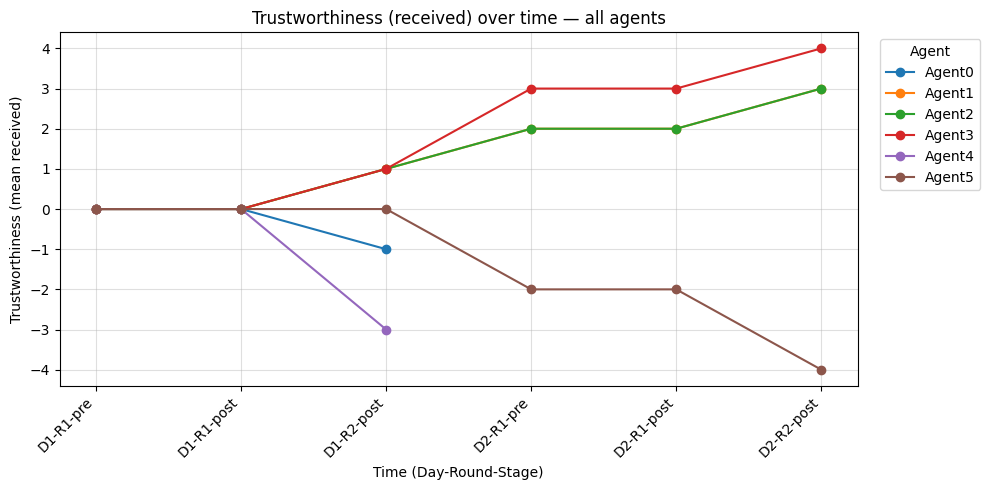

In [8]:
def plot_trustworthiness_all(ratings_received: pd.DataFrame):
    """
    Plots trustworthiness RECEIVED by each agent over time on a single figure.
    Shows:
      - Round 1 pre
      - All post stages for every round
    """
    metric = "trustworthiness"
    df = ratings_received[ratings_received["metric"] == metric].copy()
    if df.empty:
        print("No trustworthiness data to plot.")
        return

    # Keep R1 pre and all posts
    df = df[( (df["round"] == 1) & (df["stage"] == "pre") ) | (df["stage"] == "post")]

    # Ensure proper ordering: R1 pre → R1 post → R2 post → ...
    stage_order = {"pre": 0, "post": 1}
    df["stage_order"] = df["stage"].map(stage_order).fillna(0)
    df = df.sort_values(["day", "round", "stage_order"]).copy()

    # Build label
    df["t"] = df.apply(lambda r: f"D{int(r['day'])}-R{int(r['round'])}-{r['stage']}", axis=1)

    # Preserve observed order for plotting
    time_order = (
        df[["day", "round", "stage", "t", "stage_order"]]
        .drop_duplicates()
        .sort_values(["day", "round", "stage_order"])["t"]
        .tolist()
    )
    df["t"] = pd.Categorical(df["t"], categories=time_order, ordered=True)

    # Pivot wide
    wide = df.pivot_table(index="t", columns="ratee", values="received_mean", aggfunc="mean")

    # Plot
    plt.figure(figsize=(10, 5))
    for agent in sorted(wide.columns, key=lambda s: int(s.replace("Agent", ""))):
        plt.plot(wide.index.astype(str), wide[agent], marker="o", label=agent)

    plt.title("Trustworthiness (received) over time — all agents")
    plt.xlabel("Time (Day-Round-Stage)")
    plt.ylabel("Trustworthiness (mean received)")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, alpha=0.4)
    plt.legend(title="Agent", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Run it
plot_trustworthiness_all(ratings_received)


/var/folders/r5/gczqdcsj0j3c49wkn_4r75jh0000gn/T/ipykernel_86349/131097133.py:34: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = df.pivot_table(index="t", columns="ratee", values="received_mean", aggfunc="mean")


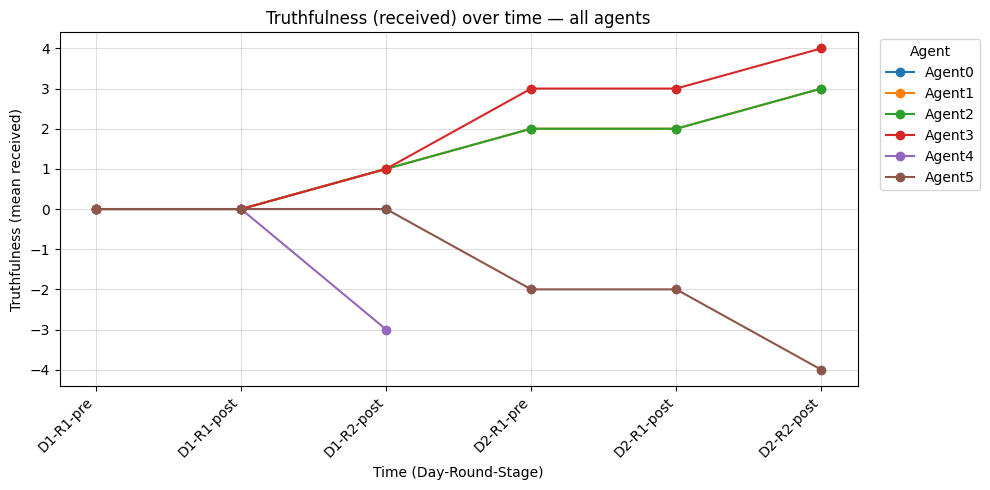

/var/folders/r5/gczqdcsj0j3c49wkn_4r75jh0000gn/T/ipykernel_86349/131097133.py:34: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = df.pivot_table(index="t", columns="ratee", values="received_mean", aggfunc="mean")


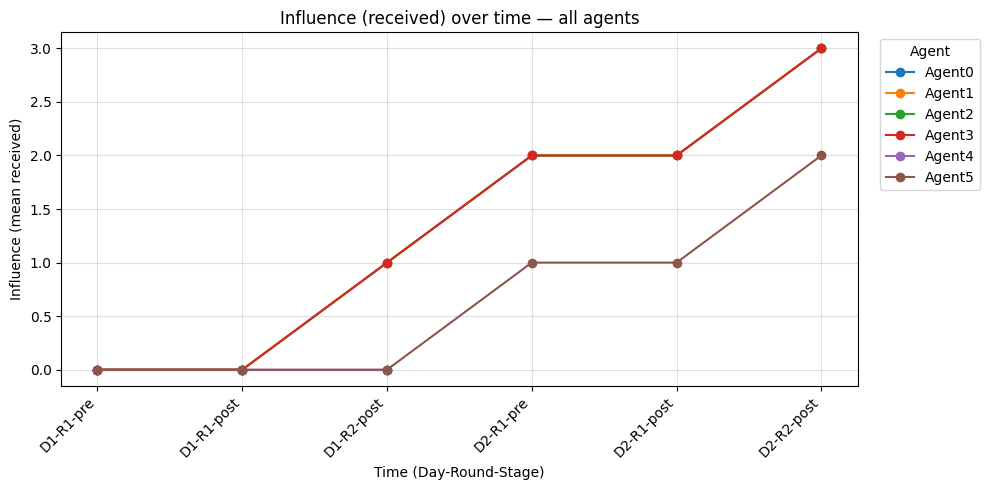

/var/folders/r5/gczqdcsj0j3c49wkn_4r75jh0000gn/T/ipykernel_86349/131097133.py:34: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = df.pivot_table(index="t", columns="ratee", values="received_mean", aggfunc="mean")


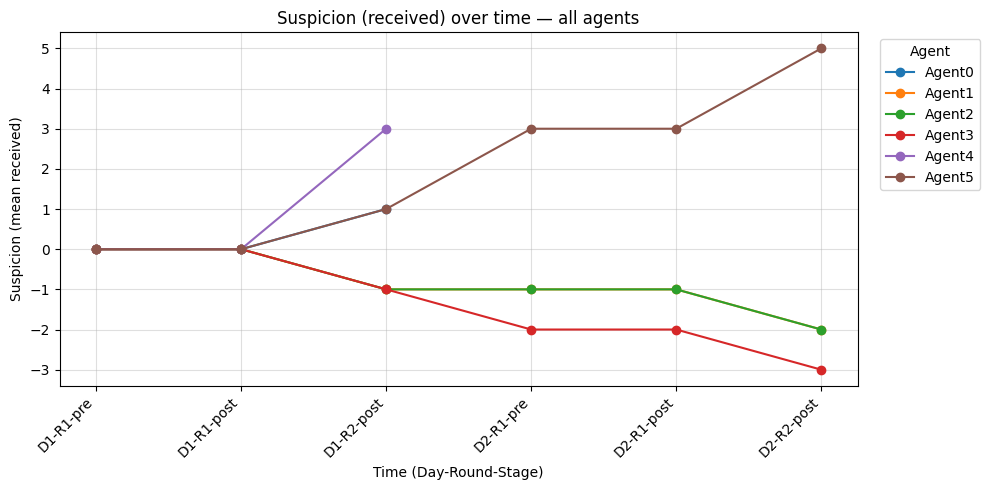

In [9]:
# --- Helper: generic multi-agent metric plot ---
def plot_metric_all_agents(ratings_received: pd.DataFrame, metric: str):
    """
    Plots RECEIVED <metric> by each agent over time on a single figure.
    - metric: one of 'truthfulness', 'influence', 'suspicion', etc.
    - Shows R1 pre, R1 post, and post stages for all subsequent rounds.
    """
    df = ratings_received[ratings_received["metric"] == metric].copy()
    if df.empty:
        print(f"No {metric} data to plot.")
        return

    # Keep only R1 pre and all posts
    df = df[((df["round"] == 1) & (df["stage"] == "pre")) | (df["stage"] == "post")]

    # Order: pre before post within same round
    stage_order = {"pre": 0, "post": 1}
    df["stage_order"] = df["stage"].map(stage_order).fillna(0)
    df = df.sort_values(["day", "round", "stage_order"]).copy()

    # Build time label
    df["t"] = df.apply(lambda r: f"D{int(r['day'])}-R{int(r['round'])}-{r['stage']}", axis=1)

    # Keep the ordering in the x-axis
    time_order = (
        df[["day", "round", "stage", "t", "stage_order"]]
        .drop_duplicates()
        .sort_values(["day", "round", "stage_order"])["t"]
        .tolist()
    )
    df["t"] = pd.Categorical(df["t"], categories=time_order, ordered=True)

    # Pivot wide
    wide = df.pivot_table(index="t", columns="ratee", values="received_mean", aggfunc="mean")

    # Plot
    plt.figure(figsize=(10, 5))
    for agent in sorted(wide.columns, key=lambda s: int(s.replace("Agent", ""))):
        plt.plot(wide.index.astype(str), wide[agent], marker="o", label=agent)

    plt.title(f"{metric.capitalize()} (received) over time — all agents")
    plt.xlabel("Time (Day-Round-Stage)")
    plt.ylabel(f"{metric.capitalize()} (mean received)")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, alpha=0.4)
    plt.legend(title="Agent", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# --- Plots for each requested metric ---
plot_metric_all_agents(ratings_received, "truthfulness")
plot_metric_all_agents(ratings_received, "influence")
plot_metric_all_agents(ratings_received, "suspicion")


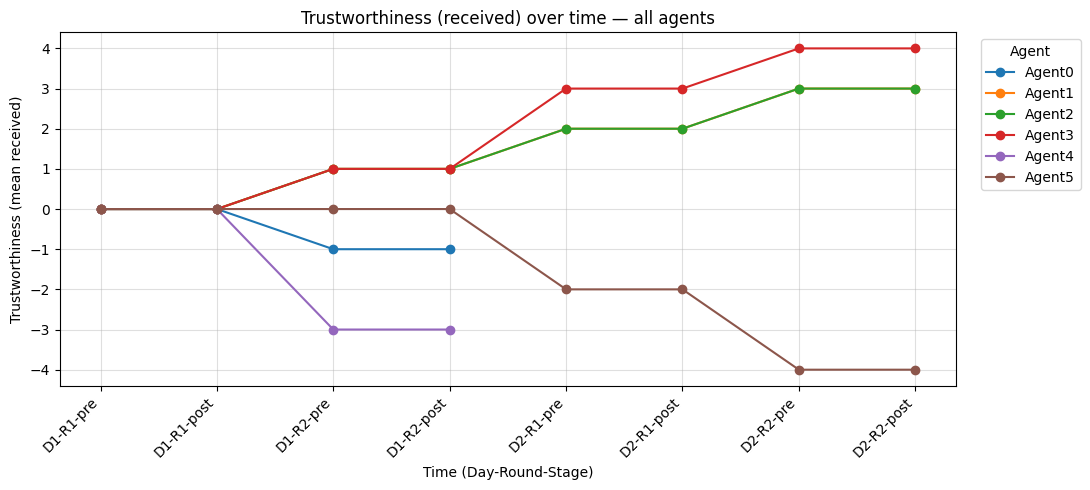

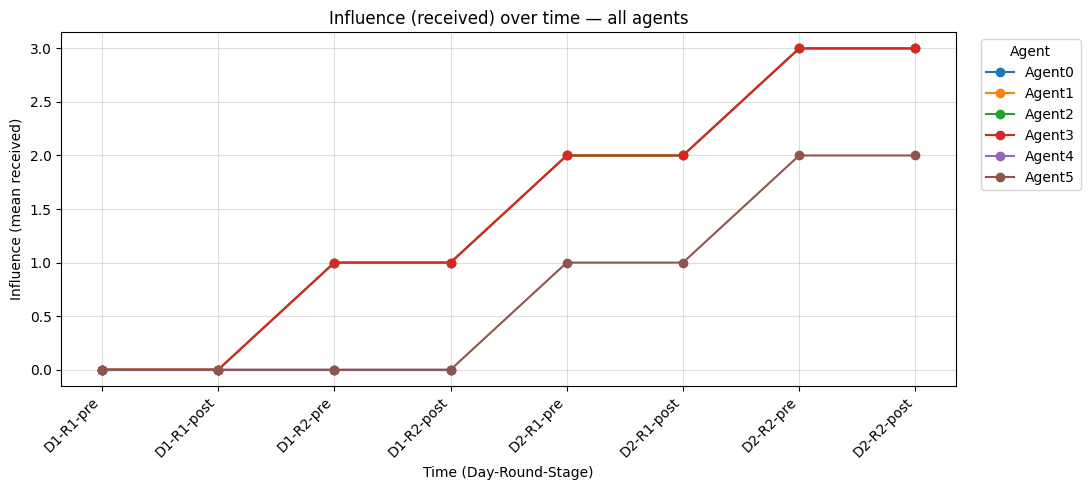

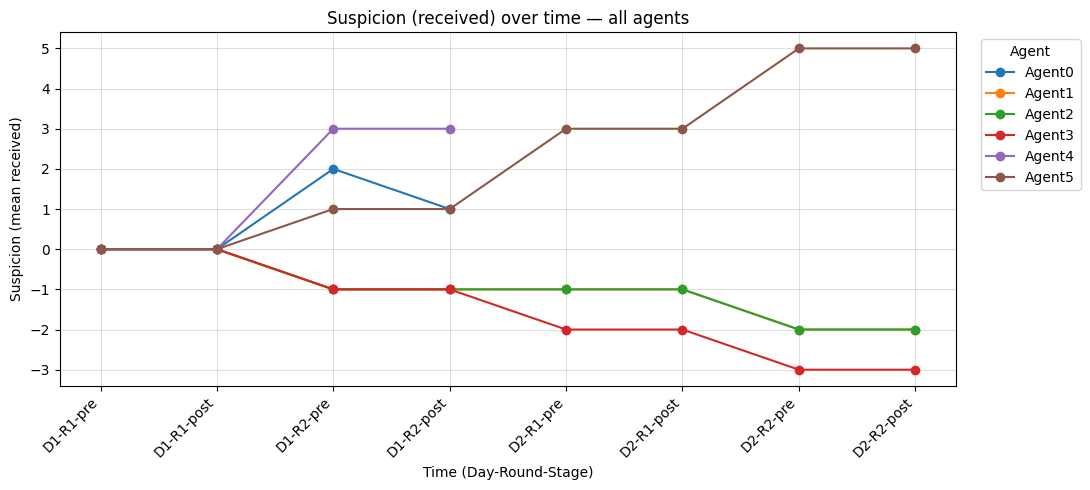

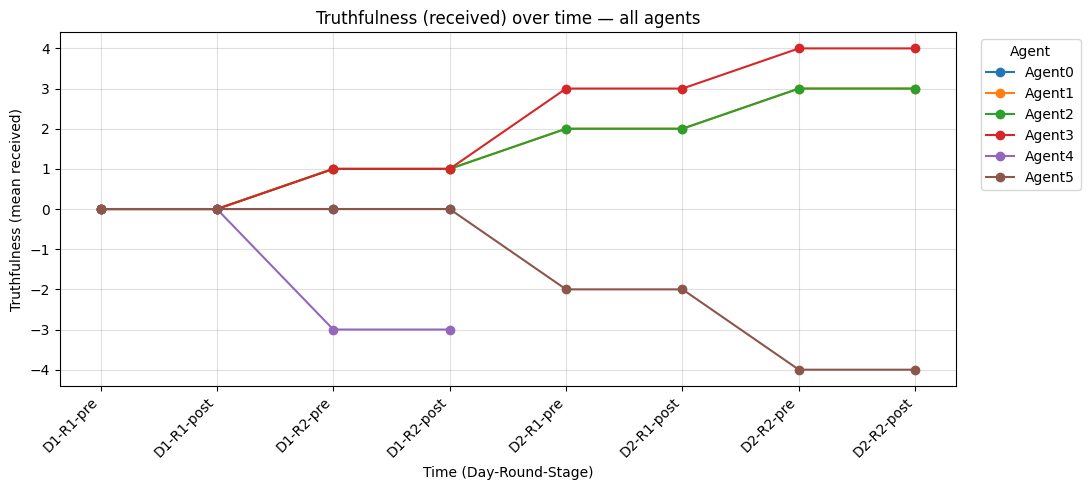

In [12]:
# --- Ensure imports (skip if already imported) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Build a full time-axis from events so days without ratings still appear ---
def build_time_axis(events_df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a DataFrame with all (day, round, stage) = ('pre'/'post') timepoints that occurred
    during DAY phases, derived from vote/rating snapshot events. Adds a 't' label and 'stage_order'.
    """
    rows = []
    for _, e in events_df.iterrows():
        if e.get("phase") != "day":
            continue
        et = e.get("event_type")
        # Prefer explicit pre/post events so timeline always has both stages
        if et in ("pre_vote_round", "post_vote_round"):
            stage = "pre" if et.startswith("pre") else "post"
        elif et in ("inter_agent_ratings", "inter_agent_ratings_snapshot"):
            stage = e.get("stage")
        else:
            continue
        if stage not in ("pre", "post"):
            continue
        rows.append({"day": int(e["day"]), "round": int(e["round"]), "stage": stage})

    # Unique + ordered timeline
    tl = (
        pd.DataFrame(rows)
        .drop_duplicates()
        .assign(stage_order=lambda d: d["stage"].map({"pre": 0, "post": 1}).fillna(0).astype(int))
        .sort_values(["day", "round", "stage_order"], kind="stable")
        .reset_index(drop=True)
    )
    tl["t"] = tl.apply(lambda r: f"D{r['day']}-R{r['round']}-{r['stage']}", axis=1)
    return tl

# --- Generic multi-agent plot that uses the scaffolded timeline ---
def plot_metric_all_agents(ratings_received: pd.DataFrame,
                           events_df: pd.DataFrame,
                           metric: str,
                           carry_forward: bool = False):
    """
    Plots RECEIVED <metric> by each agent over time on a single figure.
    Uses a full (day, round, stage) timeline built from events so all days appear.
    - metric: one of 'truthfulness', 'trustworthiness', 'influence', 'suspicion', etc.
    - carry_forward: if True, forward-fills missing values so lines don't have gaps.
    """
    # Build the scaffold (includes days/rounds even if ratings were empty)
    timeline = build_time_axis(events_df).copy()

    # Filter the metric and join to the timeline (RIGHT join -> keep every timepoint)
    df = ratings_received[ratings_received["metric"] == metric].copy()
    if df.empty:
        # Still draw an empty frame with ticks if we have a timeline
        if timeline.empty:
            print(f"No {metric} data and no timeline to show.")
            return
        # Create an empty table aligned to the timeline so the x-axis shows all days
        wide = pd.DataFrame(index=pd.Categorical(timeline["t"], categories=timeline["t"], ordered=True))
    else:
        # Match each metric row to its time label
        df = df.merge(timeline[["day", "round", "stage", "t"]], on=["day", "round", "stage"], how="right")
        # Build wide matrix (rows=time, cols=agent receiving)
        wide = df.pivot_table(index="t", columns="ratee", values="received_mean", aggfunc="mean")
        # Ensure x order follows the scaffold
        wide = wide.reindex(timeline["t"])
        if carry_forward:
            wide = wide.ffill()

    # Plot
    plt.figure(figsize=(11, 5))
    # Robust agent ordering by numeric id
    agent_cols = [c for c in (wide.columns if wide.columns is not None else []) if isinstance(c, str) and c.startswith("Agent")]
    agent_cols = sorted(agent_cols, key=lambda s: int(s.replace("Agent", "")))
    for agent in agent_cols:
        y = wide[agent]
        plt.plot(wide.index.astype(str), y, marker="o", label=agent)

    plt.title(f"{metric.capitalize()} (received) over time — all agents")
    plt.xlabel("Time (Day-Round-Stage)")
    plt.ylabel(f"{metric.capitalize()} (mean received)")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, alpha=0.4)
    if agent_cols:
        plt.legend(title="Agent", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# --- Example calls ---
plot_metric_all_agents(ratings_received, events_df, "trustworthiness", carry_forward=False)
plot_metric_all_agents(ratings_received, events_df, "influence", carry_forward=False)
plot_metric_all_agents(ratings_received, events_df, "suspicion", carry_forward=False)
plot_metric_all_agents(ratings_received, events_df, "truthfulness", carry_forward=False)
